In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
! head datadump/email_network.txt

#Sender	Recipient	time
1	2	1262454010
1	3	1262454010
1	4	1262454010
1	5	1262454010
1	6	1262454010
1	7	1262454010
1	8	1262454010
1	9	1262454010
1	10	1262454010


In [12]:
email = nx.read_edgelist('datadump/email_network.txt',nodetype=str, data=(("time", int),), create_using=nx.MultiDiGraph)

In [23]:
email

In [25]:
list(email.edges(data=True))[1:10]

[('1', '2', {'time': 1262604260}),
 ('1', '2', {'time': 1262645364}),
 ('1', '2', {'time': 1262734830}),
 ('1', '2', {'time': 1262734947}),
 ('1', '2', {'time': 1263245473}),
 ('1', '2', {'time': 1263292625}),
 ('1', '2', {'time': 1263849711}),
 ('1', '2', {'time': 1264454347}),
 ('1', '2', {'time': 1264977448})]

### Total employee counts

In [26]:
len(email.nodes)

167

### Total emails sent

In [27]:
len(email.edges)

82927

### Is it possible to have some information to have spread to everyone in the network ?

In [29]:
nx.is_strongly_connected(email)

False

When taking direction into account, it is not possible that every employee is connected in this network

However, lets look at how this changes when we consider an undirected network

In [31]:
email_ud = email.to_undirected(as_view=True)

In [33]:
len(email_ud.nodes), len(email_ud.edges)

(167, 50416)

In [34]:
nx.is_connected(email_ud)

True

We see that once we make the graph undirected, the information flow is possible

### How many nodes are there in the largest weakly connected components ?

In [52]:
comp_wk = [len(x) for x in nx.weakly_connected_components(email)]

In [58]:
sorted(comp_wk, reverse=True)[0]

167

### How many nodes are there in the largest strongly connected components ?

In [54]:
comp_st = [len(x) for x in nx.strongly_connected_components(email)]

In [57]:
sorted(comp_st, reverse=True)[0]

126

### Largest strongly connected subgraph

In [64]:
email_sc_nodes = sorted(nx.strongly_connected_components(email), reverse=True, key=len)[0]

In [69]:
email_sc = email.subgraph(email_sc_nodes)

In [70]:
len(email_sc.nodes), len(email_sc.edges)

(126, 82130)

### Average distance in the strongly connected subgraph

In [71]:
nx.average_shortest_path_length(email_sc)

1.6461587301587302

### Largest distance between 2 employees in strongly connected subgraph

In [72]:
nx.diameter(email_sc)

3

### Nodes with eccentricity equalling the diameter

In [74]:
dict(filter(lambda x: x[1] == 3, nx.eccentricity(email_sc).items()))

{'97': 3, '129': 3, '134': 3}

### Nodes with eccentricity equalling the radius

In [75]:
nx.radius(email_sc)

1

In [76]:
dict(filter(lambda x: x[1] == 1, nx.eccentricity(email_sc).items()))

{'38': 1}

### Which node is connected to most other nodes by the shortest path equalling the diameter, and how many nodes are connected to this

Initial intuition might suggest going through all pairs of nodes and finding shortest paths and then coming up with the list of nodes with shortest paths equalling diameter and finding the largest number of neighbours 

But we have already found out that nodes ['97','129','134'] are the ones with eccentricity 3 (equalling the radius) so we can just find the shortest paths from these to all others

In [82]:
def get_paths_with_length(G, src_id, length):
    paths_lengths = nx.single_source_shortest_path_length(G, src_id)
    return dict(filter(lambda x: x[1] == length, paths_lengths.items()))

def get_path_count_and_nodes_for_length(G, src_id, length):
    output = (get_paths_with_length(G, src_id, length))
    return (len(output), list(output.keys()))


In [87]:
for src_id in ['97','129','134']:
    print(src_id, "->", get_path_count_and_nodes_for_length(email_sc, src_id, 3))

97 -> (63, ['27', '26', '39', '24', '81', '29', '46', '51', '23', '8', '60', '83', '86', '149', '18', '106', '98', '40', '19', '30', '55', '43', '57', '20', '33', '34', '6', '105', '21', '123', '93', '75', '49', '16', '107', '79', '87', '52', '89', '128', '48', '82', '111', '109', '76', '151', '91', '41', '101', '124', '119', '96', '108', '110', '118', '129', '28', '99', '78', '120', '134', '121', '122'])
129 -> (1, ['134'])
134 -> (2, ['92', '97'])


### We find out that node '97' has the most shortest paths equalling 3 and has 63 other nodes it can reach with this distance

### Q: Suppose you want to prevent communication from flowing to the node that you found in the previous question from any node in the center of email_sc, what is the smallest number of nodes you would need to remove from the graph (you're not allowed to remove the node from the previous question or the center nodes)? 

Center of the graph consists of nodes that have eccentricity equal to the radius of the graph. Therefore center of the graph is node '38' as found earlier and we want to stop communication from '38' to '97'

In [98]:
nx.minimum_node_cut(email_sc, s="38",t="97")

[]

In [99]:
nx.minimum_edge_cut(email_sc, s="38",t="97")

{('14', '97'),
 ('32', '97'),
 ('37', '97'),
 ('38', '97'),
 ('45', '97'),
 ('46', '97')}

There is an edge that directly connects "38" to "97" and since we are not allowed to remove those nodes, it will always be connected. There are no nodes that you can remove that completely blocks communication without removing these two

### Construct undirected graph from the above subgraph and find the transitivity and avg clustering

In [107]:
email_un = nx.Graph(email_sc)

This collapses the MultiDirected graph into a simple undirected graph

In [108]:
type(email_un)

networkx.classes.graph.Graph

$Transitivity = \frac{3 \times \text{Number of triangles in the network}}{\text{Number of connected Triples of nodes in network}}$

In [109]:
nx.transitivity(email_un)

0.570111160700385

In [110]:
nx.average_clustering(email_un)

0.6975272437231418

In [111]:
G = nx.Graph()

In [112]:
G.add_edges_from([('A','B'), ('B','C'),('A','C'),('C','D'),('D','E'),('E','F'),('F','G'),('E','G')])

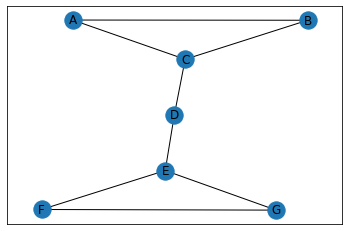

In [113]:
nx.draw_networkx(G)

In [114]:
nx.betweenness_centrality(G)

{'A': 0.0,
 'B': 0.0,
 'C': 0.5333333333333333,
 'D': 0.6,
 'E': 0.5333333333333333,
 'F': 0.0,
 'G': 0.0}

In [115]:
nx.betweenness_centrality(G,normalized=False)

{'A': 0.0, 'B': 0.0, 'C': 8.0, 'D': 9.0, 'E': 8.0, 'F': 0.0, 'G': 0.0}

In [117]:
hubs, authority = nx.hits(G)

In [118]:
hubs

{'A': 0.1276778571444571,
 'B': 0.1276778571444571,
 'C': 0.17146154102216238,
 'D': 0.14636548937784674,
 'E': 0.17146154102216238,
 'F': 0.1276778571444571,
 'G': 0.1276778571444571}

In [119]:
authority

{'A': 0.1276778569222,
 'B': 0.1276778569222,
 'C': 0.17146154186195142,
 'D': 0.14636548858729723,
 'E': 0.17146154186195142,
 'F': 0.1276778569222,
 'G': 0.1276778569222}

In [122]:
email_di = nx.DiGraph(email_sc)

In [123]:
len(email_di.nodes), len(email_di.edges)

(126, 5640)

In [124]:
nx.hits(email_di)

({'1': 0.018324994593692613,
  '2': 0.011522111311519222,
  '3': 0.01076150852664549,
  '4': 0.010712519223727446,
  '5': 0.008897291924670354,
  '6': 0.007067589296597477,
  '7': 0.012769237348884278,
  '8': 0.009372521611911124,
  '9': 0.011241963583799273,
  '10': 0.009690242695875774,
  '11': 0.004204879350964448,
  '12': 0.004397216927296167,
  '13': 0.010773581474260014,
  '14': 0.010883839375950862,
  '15': 0.009867766104725641,
  '16': 0.00407838964809333,
  '17': 0.006496107400708252,
  '18': 0.01336014960474129,
  '19': 0.007068735150295605,
  '20': 0.008352784414446935,
  '21': 0.007750400085610086,
  '22': 0.007692709725374445,
  '23': 0.011384830097516651,
  '24': 0.00736722485554258,
  '25': 0.005669119419866864,
  '26': 0.007943243886745973,
  '27': 0.01161727121432282,
  '28': 0.0029680756734263222,
  '29': 0.010941917474021285,
  '30': 0.008570778268419534,
  '31': 0.008664961832628052,
  '32': 0.010294004524724466,
  '33': 0.008002816953088332,
  '34': 0.0055247534598

In [126]:
nx.closeness_centrality(G)

{'A': 0.4,
 'B': 0.4,
 'C': 0.5454545454545454,
 'D': 0.6,
 'E': 0.5454545454545454,
 'F': 0.4,
 'G': 0.4}